overall, using K's architecture instead of local PCN, we can achieve same type qualitative conclusions: more cycles -> better performance.

In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product, chain

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
from IPython.display import display

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
# I forgot how this count_params handles BN buffer parameters (running mean and std) looks like it's ignored.
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules

load_modules()

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200515 as param_iterator_obj,
    keygen,
    encode_transfer_learning_cb19_params
)

In [5]:
# compute ccmax
from strflab.stats import cc_max

def get_cc_max_8k():
    from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

    cc_max_all_neurons = cc_max(get_neural_data_per_trial(
        ('042318', '043018','051018',))
                               )
    assert cc_max_all_neurons.shape == (79,)
    
    return cc_max_all_neurons

def get_cc_max_cb19():
    from thesis_v2.data.prepared.cadena_plos_cb19 import get_neural_data_per_trial

    cc_max_all_neurons = cc_max(get_neural_data_per_trial(fill_value='zero'))
    assert cc_max_all_neurons.shape == (115,)
    
    return cc_max_all_neurons

In [6]:
def load_everything():
    
    cc_max_all_8k = get_cc_max_8k()
    cc_max_all_cb19 = get_cc_max_cb19()
    
    _df_collect = []
    for idx, param in enumerate(
        chain(
            param_iterator_obj().generate(),
        )
    ):
        if idx % 100 == 0:
            print(idx)
            
#         if idx >= 100:
#             break
            
#         print(len(param))
#         print(len(param))

        if param['kernel_size_l23'] != 3:
            continue

#         if len(param) == 22:
#             param['train_keep'] = None
        assert len(param) == 26
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']
        
        
        
        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 50
        
        # 12 to go
        # remove smoothness_name and scale_name, 10 to go
        
#         assert param['model_seed'] == 0
        
        
        params_encoded = encode_transfer_learning_cb19_params(param)
        key = keygen(**{k: v for k, v in params_encoded.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79 + 115,)
        cc_raw_8k = cc_raw[:79]
        cc_raw_cb19 = cc_raw[79:]
        
#         if param['train_keep'] is None:
#             param['train_keep'] = 5120
        
        _df_collect.append(
            {
                'train_keep': param['train_keep'],
                'act_fn': param['act_fn'],
                'loss_type': param['loss_type'],
                'scale': float(param['scale']),
                'smoothness': float(param['smoothness']),
                'num_layer': param['num_layer'],
                'out_channel': param['out_channel'],
                # 4 to go.
                '1st_bn_before_act': param['ff_1st_bn_before_act'],
                'rcnn_bl_cls': param['rcnn_bl_cls'],
                'rcnn_acc_type': param['rcnn_acc_type'],

                'model_seed': param['model_seed'],
                'cb19_px_kept': param['cb19_px_kept'],
                # done,
                'corr_test_8k': ((cc_raw_8k/cc_max_all_8k)**2).mean(),
                'corr_test_cb19': ((cc_raw_cb19/cc_max_all_cb19)**2).mean(),
                'max_epoch': max(num_epochs),
                'num_param': count_params(result['model']),
            }
        )
    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',

        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',
        'cb19_px_kept',

        'corr_test_8k',
        'corr_test_cb19',
        'num_param',
        'max_epoch',
    ])
#     print(_df)
    _df = _df.set_index([
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',
        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',
        'cb19_px_kept',
    ], verify_integrity=True)
    return _df

In [7]:
df = load_everything()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


In [8]:
corr_mean_8k = df['corr_test_8k'].unstack('model_seed').mean(axis=1)
corr_mean_cb19 = df['corr_test_cb19'].unstack('model_seed').mean(axis=1)

# mean, max, min, all the same. for num_param
num_param = df['num_param'].unstack('model_seed').mean(axis=1)

In [9]:
# let's try to quickly eliminate bad configs, just like before, by plotting scatter plots.
def scatter(x, y, xlabel, ylabel, title):
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())

In [10]:
# here, I need to check the effective ness of act_fn, bn_before_act, bn_after_fc, loss_type
def check_compare_one_case(series_in, label_to_unstack, values_to_check=None):
    df_unstacked = series_in.unstack(label_to_unstack)
#     assert df_unstacked.shape[1] == 2
    if values_to_check is None:
        values_to_check = df_unstacked.columns.values[:2].tolist()
    else:
        pass
    
    assert len(values_to_check) == 2
    label_x = values_to_check[0]
    label_y = values_to_check[1]
        
    data_x = df_unstacked.loc[:,label_x].values
    data_y = df_unstacked.loc[:,label_y].values
    
    
    
    scatter(data_x, data_y, str(label_x), str(label_y), f'{label_to_unstack}: {label_y} vs {label_x}')

(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean 0.012607635508101461 sem 0.0013206857648434657
3 - 2 mean 0.0016547975042063544 sem 0.0009702739478616754
4 - 3 mean -0.001266330667226364 sem 0.0009259932977107658
4 - 2 mean 0.00038846683697999043 sem 0.0009874492010626538


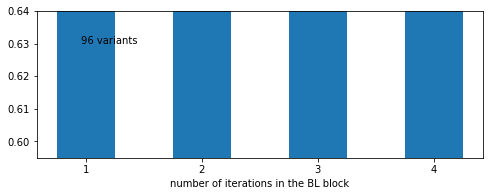

[0.7034711516952687, 0.7160787872033704, 0.7177335847075765, 0.7164672540403503] [ 1.79220363  0.23109154 -0.17643464]


,num_of_cycles,performance,gain %
0,1,0.703471,NaN
1,2,0.716079,1.792204
2,3,0.717734,0.231092
3,4,0.716467,-0.176435


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.01141418217566615 sem 0.002001285033573137
3 - 2 mean 0.002807236221986057 sem 0.001577594019512398
4 - 3 mean -0.00321748829193357 sem 0.0012571893487194695
4 - 2 mean -0.0004102520699475129 sem 0.0015205806706098779


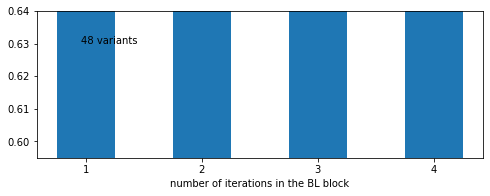

[0.7109495645523918, 0.722363746728058, 0.725170982950044, 0.7219534946581104] [ 1.60548409  0.38861809 -0.44368685]


,num_of_cycles,performance,gain %
0,1,0.710950,NaN
1,2,0.722364,1.605484
2,3,0.725171,0.388618
3,4,0.721953,-0.443687


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.01380108884053677 sem 0.0017065622324449938
3 - 2 mean 0.000502358786426652 sem 0.001105253419025912
4 - 3 mean 0.0006848269574808418 sem 0.0013002705953897213
4 - 2 mean 0.0011871857439074939 sem 0.0012495906505890489


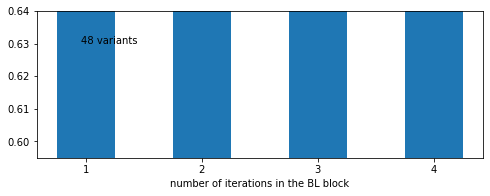

[0.6959927388381457, 0.7097938276786824, 0.7102961864651091, 0.7109810134225899] [1.98293575 0.07077531 0.09641428]


,num_of_cycles,performance,gain %
0,1,0.695993,NaN
1,2,0.709794,1.982936
2,3,0.710296,0.070775
3,4,0.710981,0.096414


In [11]:
def plot_step_increase(df_this, pairs_to_check, ylim):
    # remove those no innner act ones.
    df_unstacked = df_this.unstack('rcnn_bl_cls')
#     df_unstacked = corr_mean.unstack('pcn_cls')
    print(df_unstacked.shape)
    
#     selector = df_unstacked.values[:,0] >= 0.50
    selector = ()
#     print(selector.mean())
    
    cls_values = df_unstacked.columns.values.tolist()
    print(cls_values)
    assert cls_values == list(range(1,len(cls_values)+1))
    
    n = df_unstacked.shape[0]
    
#     n = selector.sum()
    print('n', n)
    
    
    for p1, p2 in pairs_to_check:
        val0 = df_unstacked.values[:,p1-1][selector]
        val1 = df_unstacked.values[:,p2-1][selector]

        # selection
        print(
            f'{p2} - {p1}',
            'mean', (val1-val0).mean(),
            'sem', (val1-val0).std()/np.sqrt(n)
        )
        
    # time to plot.
    # show results for cls_values[0] through cls_values[-1]
    # for the first one, just show mean,
    # for others show mean and s.e.m. of increase.
    
    mean_performance = []
    sem_increase = []
    labels = []
    
    for idx, cls_name in enumerate(cls_values):
        assert idx == cls_name - 1
        mean_performance.append(df_unstacked.values[:,idx][selector].mean())
        if idx == 0:
            sem_increase.append(0.0)
        else:
            sem_increase.append((df_unstacked.values[:,idx][selector]-df_unstacked.values[:,idx-1][selector]).std()/np.sqrt(n))
        labels.append(str(cls_name))
        
    
    plt.close('all')
    fig = plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(cls_values)), mean_performance, 0.5, yerr=sem_increase)
#     plt.ylabel('neural prediction performance')
    plt.ylim(*ylim)
    plt.xlabel('number of iterations in the BL block')
    plt.xticks(np.arange(len(cls_values)), labels)
    
    
    plt.text(0.1, 0.8, f'{n} variants', verticalalignment='center', horizontalalignment='left', transform=plt.gca().transAxes)
    fig.subplots_adjust(bottom=0.2)

    plt.show()
    
    print(mean_performance, np.diff(mean_performance)/mean_performance[:-1]*100)
    
    display(pd.DataFrame(
        data = {
            'num_of_cycles': cls_values,
            'performance': mean_performance,
            'gain %': np.concatenate([np.asarray([np.nan]),  np.diff(mean_performance)/mean_performance[:-1]*100])
        },
        columns = ['num_of_cycles', 'performance', 'gain %']
    ))
    
    
    
# trend for 0-1-2 is good. then bad.
plot_step_increase(corr_mean_8k.xs('full', level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.595, 0.64))
plot_step_increase(corr_mean_8k.xs('full', level='train_keep').xs(100, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.595, 0.64))
plot_step_increase(corr_mean_8k.xs('full', level='train_keep').xs(80, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.595, 0.64))

(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean 0.021696636300327365 sem 0.0029535548413114217
3 - 2 mean 0.005925670126987169 sem 0.0017291405166484685
4 - 3 mean 0.0019587590260761374 sem 0.0016407012551313694
4 - 2 mean 0.007884429153063305 sem 0.002287753553537248


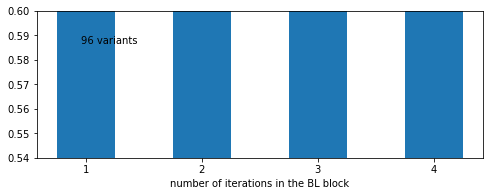

[0.6215937573762588, 0.643290393676586, 0.6492160638035732, 0.6511748228296493] [3.49048491 0.9211501  0.30171142]


,num_of_cycles,performance,gain %
0,1,0.621594,NaN
1,2,0.643290,3.490485
2,3,0.649216,0.921150
3,4,0.651175,0.301711


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.022719475290936708 sem 0.0035934247960254487
3 - 2 mean 0.005065654286227453 sem 0.0022842420806429074
4 - 3 mean 0.0027223443399760072 sem 0.0022381781523724063
4 - 2 mean 0.007787998626203461 sem 0.0025480641156480806


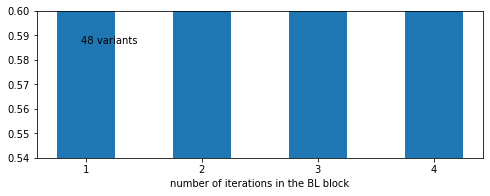

[0.6285569241954991, 0.6512763994864359, 0.6563420537726633, 0.6590643981126393] [3.61454538 0.77780406 0.41477524]


,num_of_cycles,performance,gain %
0,1,0.628557,NaN
1,2,0.651276,3.614545
2,3,0.656342,0.777804
3,4,0.659064,0.414775


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.020673797309718026 sem 0.004683764659738615
3 - 2 mean 0.006785685967746885 sem 0.002590584493960759
4 - 3 mean 0.0011951737121762677 sem 0.0023945493773257836
4 - 2 mean 0.007980859679923152 sem 0.003800295659221511


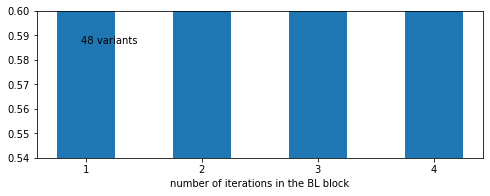

[0.6146305905570183, 0.6353043878667364, 0.6420900738344831, 0.6432852475466595] [3.36361347 1.06809997 0.18613801]


,num_of_cycles,performance,gain %
0,1,0.614631,NaN
1,2,0.635304,3.363613
2,3,0.642090,1.068100
3,4,0.643285,0.186138


In [12]:
plot_step_increase(corr_mean_8k.xs('half', level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.60))
plot_step_increase(corr_mean_8k.xs('half', level='train_keep').xs(100, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.60))
plot_step_increase(corr_mean_8k.xs('half', level='train_keep').xs(80, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.60))



(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean 0.002735319296652433 sem 0.0066084774707918
3 - 2 mean 0.0151942422778537 sem 0.0037004697626531573
4 - 3 mean 0.009234303070473836 sem 0.0037876646199374846
4 - 2 mean 0.024428545348327533 sem 0.004392692115727919


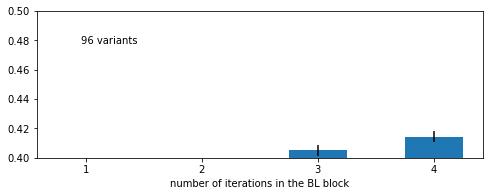

[0.38731961852056473, 0.3900549378172172, 0.4052491800950708, 0.4144834831655448] [0.7062176  3.89541083 2.27867286]


,num_of_cycles,performance,gain %
0,1,0.387320,NaN
1,2,0.390055,0.706218
2,3,0.405249,3.895411
3,4,0.414483,2.278673


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.0018180692037607145 sem 0.010487138185867793
3 - 2 mean 0.012449744335558488 sem 0.004823602412856439
4 - 3 mean 0.009114353708673872 sem 0.004346025655538903
4 - 2 mean 0.021564098044232354 sem 0.005147681791430994


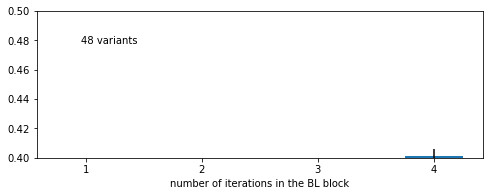

[0.37796532959696716, 0.3797833988007279, 0.39223314313628643, 0.40134749684496035] [0.48101481 3.27811705 2.3237082 ]


,num_of_cycles,performance,gain %
0,1,0.377965,NaN
1,2,0.379783,0.481015
2,3,0.392233,3.278117
3,4,0.401347,2.323708


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.0036525693895441535 sem 0.008041938475444014
3 - 2 mean 0.01793874022014891 sem 0.005585062316583781
4 - 3 mean 0.0093542524322738 sem 0.006204601083081609
4 - 2 mean 0.02729299265242271 sem 0.007095242831425993


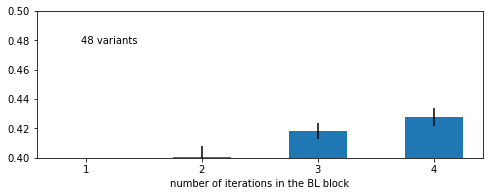

[0.3966739074441623, 0.4003264768337064, 0.4182652170538554, 0.4276194694861291] [0.920799   4.48102768 2.23644043]


,num_of_cycles,performance,gain %
0,1,0.396674,NaN
1,2,0.400326,0.920799
2,3,0.418265,4.481028
3,4,0.427619,2.236440


In [13]:
plot_step_increase(corr_mean_8k.xs('quarter', level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.4, 0.5))
plot_step_increase(corr_mean_8k.xs('quarter', level='train_keep').xs(100, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.4, 0.5))
plot_step_increase(corr_mean_8k.xs('quarter', level='train_keep').xs(80, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.4, 0.5))

In [14]:
# check relationship between num_param and performance, colored for different num_of_cycles.

(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean 0.01253188274780565 sem 0.0016086548378870893
3 - 2 mean 0.0025635024777472173 sem 0.0013153070581148098
4 - 3 mean -0.0018413596576098777 sem 0.0011779561532522383
4 - 2 mean 0.0007221428201373397 sem 0.001389272842429456


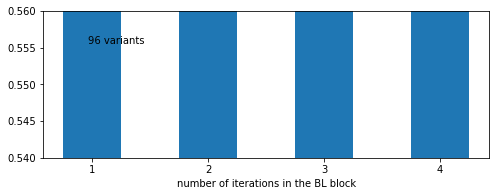

[0.5996301585918495, 0.6121620413396551, 0.6147255438174024, 0.6128841841597925] [ 2.08993537  0.41876208 -0.29954175]


,num_of_cycles,performance,gain %
0,1,0.599630,NaN
1,2,0.612162,2.089935
2,3,0.614726,0.418762
3,4,0.612884,-0.299542


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.012763010059733126 sem 0.002459410967272909
3 - 2 mean 0.004581743747505587 sem 0.00188247053328063
4 - 3 mean -0.0035991524851915133 sem 0.0014326652144912196
4 - 2 mean 0.0009825912623140736 sem 0.0016392496945018442


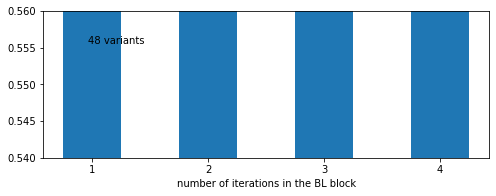

[0.6049215030020111, 0.6176845130617442, 0.6222662568092497, 0.6186671043240582] [ 2.10986219  0.74176115 -0.57839429]


,num_of_cycles,performance,gain %
0,1,0.604922,NaN
1,2,0.617685,2.109862
2,3,0.622266,0.741761
3,4,0.618667,-0.578394


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.012300755435878169 sem 0.0020736811272367628
3 - 2 mean 0.0005452612079888478 sem 0.0017907301799024676
4 - 3 mean -8.356683002824193e-05 sem 0.0018354972154969377
4 - 2 mean 0.00046169437796060586 sem 0.0022428442145255383


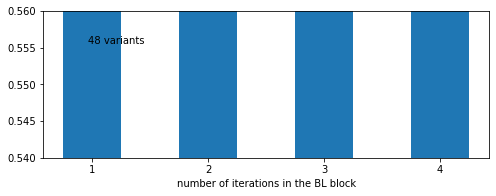

[0.5943388141816879, 0.606639569617566, 0.6071848308255549, 0.6071012639955268] [ 2.06965373  0.08988224 -0.013763  ]


,num_of_cycles,performance,gain %
0,1,0.594339,NaN
1,2,0.606640,2.069654
2,3,0.607185,0.089882
3,4,0.607101,-0.013763


In [15]:
plot_step_increase(corr_mean_cb19.xs('full', level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.56))
plot_step_increase(corr_mean_cb19.xs('full', level='train_keep').xs(100, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.56))
plot_step_increase(corr_mean_cb19.xs('full', level='train_keep').xs(80, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.56))

(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean 0.01697610987795998 sem 0.0021715241590964667
3 - 2 mean 0.0018527258034633936 sem 0.001349943786840867
4 - 3 mean -0.00021319181630968334 sem 0.0014658167777841745
4 - 2 mean 0.0016395339871537104 sem 0.0016633662256614397


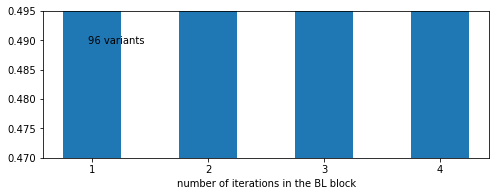

[0.5138598223672716, 0.5308359322452315, 0.532688658048695, 0.5324754662323853] [ 3.30364608  0.34902042 -0.04002184]


,num_of_cycles,performance,gain %
0,1,0.513860,NaN
1,2,0.530836,3.303646
2,3,0.532689,0.349020
3,4,0.532475,-0.040022


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.018339399065005983 sem 0.002968002792699996
3 - 2 mean 0.0013116941794934153 sem 0.0018977602568291479
4 - 3 mean 0.0017188448473546617 sem 0.0018499164587291882
4 - 2 mean 0.0030305390268480768 sem 0.0017863841207304558


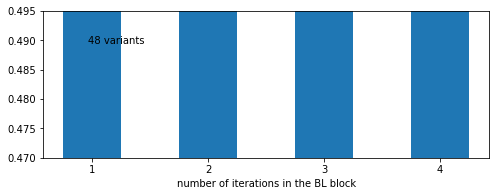

[0.5214167046693533, 0.5397561037343592, 0.5410677979138527, 0.5427866427612074] [3.51722507 0.24301609 0.31767643]


,num_of_cycles,performance,gain %
0,1,0.521417,NaN
1,2,0.539756,3.517225
2,3,0.541068,0.243016
3,4,0.542787,0.317676


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.015612820690913973 sem 0.0031584154610664558
3 - 2 mean 0.002393757427433372 sem 0.0019172121558915932
4 - 3 mean -0.0021452284799740283 sem 0.0022398108172234565
4 - 2 mean 0.0002485289474593438 sem 0.0027920171829762287


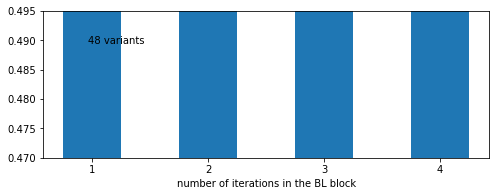

[0.5063029400651898, 0.5219157607561039, 0.5243095181835372, 0.5221642897035632] [ 3.08369149  0.45864824 -0.40915307]


,num_of_cycles,performance,gain %
0,1,0.506303,NaN
1,2,0.521916,3.083691
2,3,0.524310,0.458648
3,4,0.522164,-0.409153


In [16]:
plot_step_increase(corr_mean_cb19.xs('half', level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.47, 0.495))
plot_step_increase(corr_mean_cb19.xs('half', level='train_keep').xs(100, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.47, 0.495))
plot_step_increase(corr_mean_cb19.xs('half', level='train_keep').xs(80, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.47, 0.495))

(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean 0.0043674800745886685 sem 0.00416922117895608
3 - 2 mean 0.014141443942355947 sem 0.0031802110145629572
4 - 3 mean 0.0071579949773018054 sem 0.0029248697099110437
4 - 2 mean 0.021299438919657753 sem 0.003943733335399551


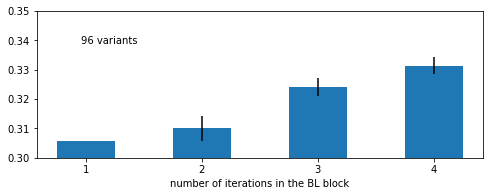

[0.30562594708858126, 0.30999342716316997, 0.3241348711055259, 0.3312928660828277] [1.42902791 4.56185283 2.20833845]


,num_of_cycles,performance,gain %
0,1,0.305626,NaN
1,2,0.309993,1.429028
2,3,0.324135,4.561853
3,4,0.331293,2.208338


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.0028842630827540486 sem 0.0069198651738998735
3 - 2 mean 0.014700863084161625 sem 0.004354955328004099
4 - 3 mean 0.005623894877131143 sem 0.003444632717180219
4 - 2 mean 0.02032475796129277 sem 0.004544855715510516


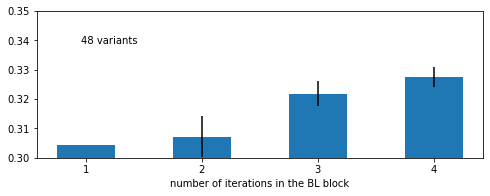

[0.3042923918407416, 0.3071766549234956, 0.3218775180076572, 0.32750141288478835] [0.94785909 4.78580089 1.74721581]


,num_of_cycles,performance,gain %
0,1,0.304292,NaN
1,2,0.307177,0.947859
2,3,0.321878,4.785801
3,4,0.327501,1.747216


(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.0028842630827540486 sem 0.0069198651738998735
3 - 2 mean 0.014700863084161625 sem 0.004354955328004099
4 - 3 mean 0.005623894877131143 sem 0.003444632717180219
4 - 2 mean 0.02032475796129277 sem 0.004544855715510516


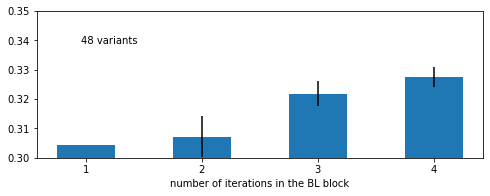

[0.3042923918407416, 0.3071766549234956, 0.3218775180076572, 0.32750141288478835] [0.94785909 4.78580089 1.74721581]


,num_of_cycles,performance,gain %
0,1,0.304292,NaN
1,2,0.307177,0.947859
2,3,0.321878,4.785801
3,4,0.327501,1.747216


In [17]:
plot_step_increase(corr_mean_cb19.xs('quarter', level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.3, 0.35))
plot_step_increase(corr_mean_cb19.xs('quarter', level='train_keep').xs(100, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.3, 0.35))
plot_step_increase(corr_mean_cb19.xs('quarter', level='train_keep').xs(100, level='cb19_px_kept'), [(1,2),(2,3),(3,4),(2,4)], (0.3, 0.35))